## Задача
### Реализовать три типа фильтров изображения:
### 1. Фильтр размытия
### 2. Фильтр увеличения чёткости
### 3. Медианный фильтр избавления от шумов

### Группа: КВБО-07-21
### Выполняли: Быковский В.А., Ванюшин С.Р., Данилова Д.П.

## 1. Загрузка изображения

Image size is: (720, 1080)
Data type of image is: uint8


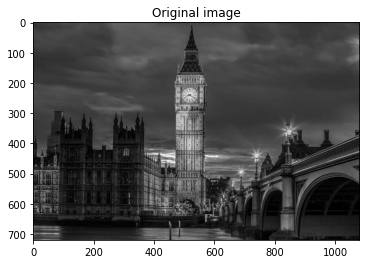

[[ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  61  62  62]
 ...
 [ 87  83  78 ...  15  16  16]
 [134 125 112 ...  13  14  15]
 [150 138 120 ...  11  12  14]]


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

img = cv2.imread('big-ben.jpg', cv2.IMREAD_GRAYSCALE)
#cv2.imshow('Picture', img)
#cv2.waitKey(0)

print("Image size is:", img.shape)
print("Data type of image is:", img.dtype)

plt.figure
plt.imshow(img, cmap='gray')
plt.title("Original image")
plt.show()

print(img)

## 2. Реализация функций заполнения изображения шумами

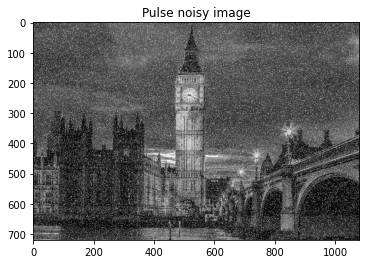

[[ 52 255  52 ...  60  61  61]
 [ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  61  62  62]
 ...
 [ 87  83  78 ...  15  16  16]
 [134 125 112 ...  13  14  15]
 [150 138 120 ...  11  12  14]]


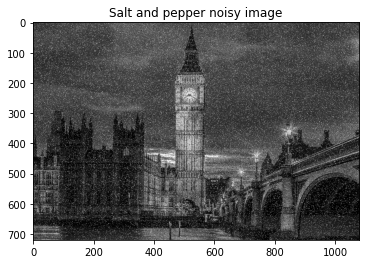

[[ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  60  61  61]
 [ 52  52  52 ...  61  62  62]
 ...
 [  0  83  78 ...  15  16  16]
 [134 125 112 ...  13 255  15]
 [150 138   0 ...  11  12 255]]


In [2]:
def pulse_noise_generator(img):
    """
    Осуществляет заполнение изображения импульсным шумом
    
    :param img: матрица исходного изображения
    
    :return noisy_img: матрица зашумленного изображения
    """
    noise_share = 0.1
    noisy_img = np.copy(img)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if noise_share >= random.random():
                noisy_img[i, j] = 255
                
    return noisy_img

def salt_and_pepper_noise_generator(img):
    """
    Осуществляет заполнение изображения шумом типа соль-перец
    
    :param img: матрица исходного изображения
    
    :return noisy_img: матрица зашумленного изображения
    """
    noise_share = 0.1
    noisy_img = np.copy(img)
    
    for i in range(noisy_img.shape[0]):
        for j in range(noisy_img.shape[1]):
            if noise_share >= random.random():
                noisy_img[i, j] = 0 if bool(random.getrandbits(1)) else 255
                
    return noisy_img
    
pulse_noisy_img = pulse_noise_generator(img)
salt_and_pepper_noisy_img = salt_and_pepper_noise_generator(img)

plt.imshow(pulse_noisy_img, cmap='gray')
plt.title("Pulse noisy image")
plt.show()

print(pulse_noisy_img)

plt.imshow(salt_and_pepper_noisy_img, cmap='gray')
plt.title("Salt and pepper noisy image")
plt.show()

print(salt_and_pepper_noisy_img)

## 3. Реализация функции расширения изображения

In [3]:
def image_expansion(img, kernel_dimension=3):
    """
    Осуществляет расширение матрицы исходного изображения нулями со всех сторон
    
    :param img: матрица исходного изображения
    :param kernel_dimension: размерность матрицы фильтра для каждой из осей. Принимаются только нечётные значния, начиная c 0.
    
    :return extended_img: расширенная матрица
    """
    diff = kernel_dimension // 2 # величина расширения
    
    extended_img = np.concatenate(
        (np.zeros((img.shape[0], diff), dtype='uint8'),
         img,
         np.zeros((img.shape[0], diff), dtype='uint8'),
         ),
        dtype='uint8',
        axis=1
    )

    extended_img = np.concatenate(
        (np.zeros((diff, img.shape[1] + diff * 2), dtype='uint8'),
         extended_img,
         np.zeros((diff, img.shape[1] + diff * 2), dtype='uint8'),
         ),
        dtype='uint8'
    )

    return extended_img

## 4. Реализация функция фильтрации изображения

In [4]:
def blur_filter(img, kernel_dimension=3):
    """
    Осуществляет размытие изображения
    
    :param img: матрица исходного изображения
    :param kernel_dimension: размерность матрицы фильтра для каждой из осей. Принимаются только нечётные значния, начиная c 0.
    
    :return blur_img: матрица размытого изображения
    """
    diff = kernel_dimension // 2 # величина расширения
    
    blur_img = np.zeros(img.shape, dtype='uint8')
    img = image_expansion(img, kernel_dimension)
    blur_kernel = 1/np.power(kernel_dimension, 2) * np.array([[1] * kernel_dimension] * kernel_dimension)
    
    for i in range(diff, img.shape[0] - diff):
        for j in range(diff, img.shape[1] - diff):
            submatrix = img[i - diff : i + diff + 1, j - diff : j + diff + 1]
            blur_img[i - diff, j - diff] = np.sum(np.multiply(submatrix, blur_kernel))
    
    return blur_img

def sharp_filter(img):
    """
    Осуществляет увеличение резкости изображения
    
    :param img: матрица исходного изображения
    
    :return sharp_img: матрица изображения с увеличенной резкостью
    """
    sharp_img = np.zeros(img.shape, dtype='uint8')
    img = image_expansion(img)
    sharp_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            submatrix = img[i - 1 : i + 2, j - 1 : j + 2]
            sharp_img[i - 1, j - 1] = np.sum(np.multiply(submatrix, sharp_kernel))
    
    return sharp_img

def median_filter(img, kernel_dimension=3):
    """
    Осуществляет фильтрацию изображения от шумов
    
    :param img: матрица исходного изображения
    :param kernel_dimension: размерность матрицы фильтра для каждой из осей. Принимаются только нечётные значния, начиная c 0.
    
    :return median_img: отфильтрованное изображение
    """
    diff = kernel_dimension // 2 # величина расширения
    
    median_img = np.zeros(img.shape, dtype='uint8')
    img = image_expansion(img, kernel_dimension)
    
    for i in range(diff, img.shape[0] - diff):
        for j in range(diff, img.shape[1] - diff):
            submatrix = img[i - diff : i + diff + 1, j - diff : j + diff + 1]
            
            sorted_env = np.sort(submatrix.flatten())
            median_img[i - diff, j - diff] = sorted_env[len(sorted_env) // 2]

    return median_img

## 5. Окончательный результат

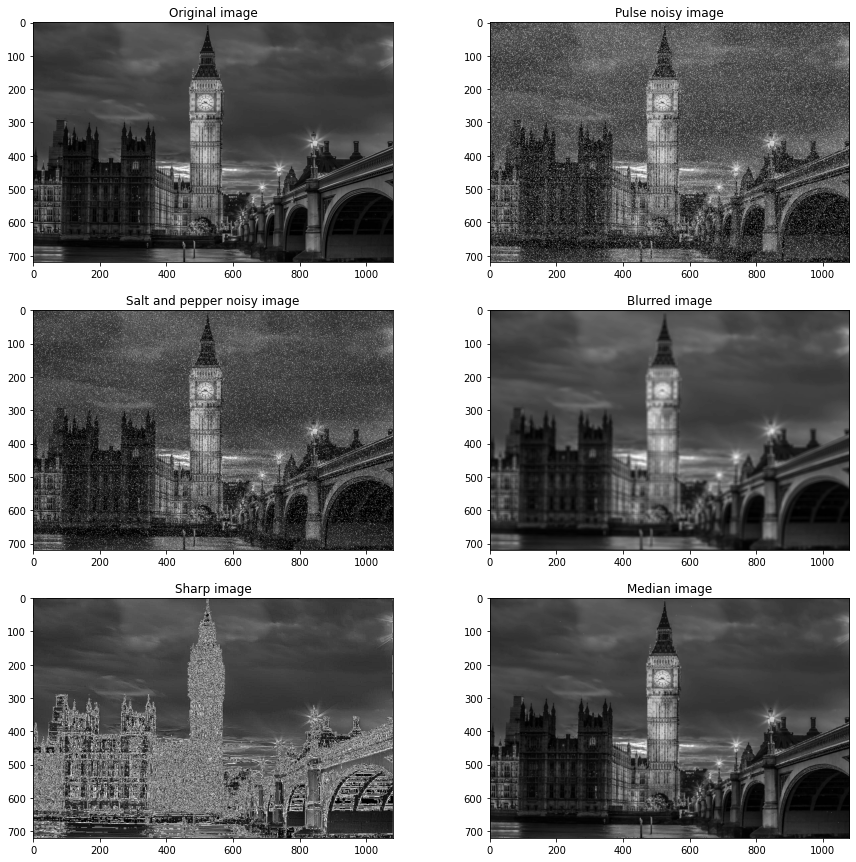

In [5]:
plt.figure(figsize=[15, 15])

plt.subplot(321)
plt.imshow(img, cmap='gray')
plt.title("Original image")

plt.subplot(322)
plt.imshow(pulse_noisy_img, cmap='gray')
plt.title("Pulse noisy image")

plt.subplot(323)
plt.imshow(salt_and_pepper_noisy_img, cmap='gray')
plt.title("Salt and pepper noisy image")

plt.subplot(324)
plt.imshow(blur_filter(img, 9), cmap='gray')
plt.title("Blurred image")

plt.subplot(325)
plt.imshow(sharp_filter(img), cmap='gray')
plt.title("Sharp image")

plt.subplot(326)
plt.imshow(median_filter(salt_and_pepper_noisy_img), cmap='gray')
plt.title("Median image")

plt.show()